<a href="https://colab.research.google.com/github/Kshitij-Ambilduke/Memes-vs-Notes/blob/master/Dense.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import random
import numpy as np

In [3]:
meme_path = "/content/drive/My Drive/dataset stage 0 /meme"
note_path = "/content/drive/My Drive/dataset stage 0 /note"

In [4]:
def dataloader(folder,label):
    images=[]
    labels=[]
    for file in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (100,100))
        images.append(img)
        labels.append(label)
    return images, labels
        

In [5]:
meme, memelabel = dataloader(meme_path, 1)
note, notelabel = dataloader(note_path, 0)

In [6]:
meme = np.array(meme)
memelabel = np.array(memelabel)
print(meme.__len__())

800


In [7]:
meme = meme.reshape(800,3,100,100)
note = np.array(note)
note = note.reshape(800,3,100,100)
notelabel = np.array(notelabel)
print(len(notelabel))

800


In [8]:
print(note.shape)
print(meme.shape)

(800, 3, 100, 100)
(800, 3, 100, 100)


In [9]:
memezip = list(zip(meme, memelabel))
notezip = list(zip(note, notelabel))

In [28]:
toshuffle = []
toshuffle = memezip[0:750] + notezip[0:750]
random.shuffle(toshuffle)
xtrain, ytrain = list(zip(*toshuffle))

toshuffle = []
toshuffle = memezip[750:775] + notezip[750:775]
random.shuffle(toshuffle)
xtest, ytest = list(zip(*toshuffle))

toshuffle = []
toshuffle = memezip[775:] + notezip[775:]
random.shuffle(toshuffle)
xval, yval = list(zip(*toshuffle))

In [29]:
xtrain = torch.Tensor(xtrain)
xtest = torch.Tensor(xtest)
xval = torch.Tensor(xval)
ytrain = torch.Tensor(ytrain).long()
ytest = torch.Tensor(ytest).long()
yval = torch.Tensor(yval).long()
xtrain/=255.0
xtest/=255.0
xval /=255.0

In [38]:
class DenseNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense1 = nn.Linear(30000, 10000)
        self.dense2 = nn.Linear(10000, 5000)
        self.dense3 = nn.Linear(5000,1000)
        self.dense4 = nn.Linear(1000,500)
        self.dense5 = nn.Linear(500,100)
        self.dense6 = nn.Linear(100,50)
        self.dense7 = nn.Linear(50,2)
    def forward(self,x):
        x = x.flatten(1)
        x = self.dense1(x)
        x = F.relu(x)
        x = self.dense2(x)
        x = F.relu(x)
        x = self.dense3(x)
        x = F.relu(x)
        x = self.dense4(x)
        x = F.relu(x)
        x = self.dense5(x)
        x = F.relu(x)
        x = self.dense6(x)
        x = F.relu(x)
        x = self.dense7(x)
        return x

In [39]:
net = DenseNet()
print(net)

DenseNet(
  (dense1): Linear(in_features=30000, out_features=10000, bias=True)
  (dense2): Linear(in_features=10000, out_features=5000, bias=True)
  (dense3): Linear(in_features=5000, out_features=1000, bias=True)
  (dense4): Linear(in_features=1000, out_features=500, bias=True)
  (dense5): Linear(in_features=500, out_features=100, bias=True)
  (dense6): Linear(in_features=100, out_features=50, bias=True)
  (dense7): Linear(in_features=50, out_features=2, bias=True)
)


In [40]:
optimizer = torch.optim.Adam(net.parameters(),lr=0.00001)
vlossfn = nn.CrossEntropyLoss()
lossfn = nn.CrossEntropyLoss()

In [41]:
print(xtrain.shape)
print(xtest.shape)
print(xval.shape)

torch.Size([1500, 3, 100, 100])
torch.Size([50, 3, 100, 100])
torch.Size([50, 3, 100, 100])


In [42]:
def accuracy(label, pred):
  count =0
  pred = torch.argmax(pred, dim=1, keepdims=True)
  pred = pred.reshape(pred.shape[0])
  for i in range(len(label)):
    if label[i]==pred[i]:
      count+=1
  return 100*count/label.shape[0]


In [43]:
print(xtest.shape)

torch.Size([50, 3, 100, 100])


In [44]:
trainacc = []
testacc = []
trainloss = []
testloss = []
valacc = []
valloss = []

for i in range(7):
    k=0
    for j in range(30): 
      
      output = net.forward(xtrain[k:k+50])
      loss = lossfn(output, ytrain[k:k+50])
        
      k+=50
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    
    with torch.no_grad():

      accu = accuracy(ytrain, net.forward(xtrain))
      vloss = lossfn(net.forward(xval),yval)
      tacc = accuracy(ytest, net.forward(xtest))
      vacc = accuracy(yval,net.forward(xval))

    
    print(f"training loss:{loss}")
    trainloss.append(loss)
    print(f"validation loss:{vloss}")
    valloss.append(vloss.item())
    print(f"training accuracy:{accu}")
    trainacc.append(accu)
    print(f"validation accuracy:{vacc}")
    valacc.append(vacc)
    print(f"testing accuracy:{tacc}")
    testacc.append(tacc)
    print()

training loss:0.6069009304046631
validation loss:0.6248615384101868
training accuracy:75.33333333333333
validation accuracy:76.0
testing accuracy:84.0

training loss:0.42739298939704895
validation loss:0.5062243938446045
training accuracy:73.26666666666667
validation accuracy:76.0
testing accuracy:82.0

training loss:0.3408723473548889
validation loss:0.4553183317184448
training accuracy:75.53333333333333
validation accuracy:76.0
testing accuracy:82.0

training loss:0.28315696120262146
validation loss:0.38766899704933167
training accuracy:79.73333333333333
validation accuracy:78.0
testing accuracy:88.0

training loss:0.21504557132720947
validation loss:0.33857595920562744
training accuracy:84.73333333333333
validation accuracy:82.0
testing accuracy:90.0

training loss:0.13965366780757904
validation loss:0.2933914363384247
training accuracy:87.53333333333333
validation accuracy:86.0
testing accuracy:92.0

training loss:0.08705905824899673
validation loss:0.24434098601341248
training acc

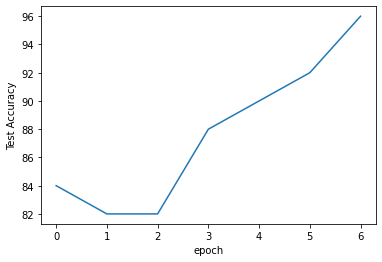

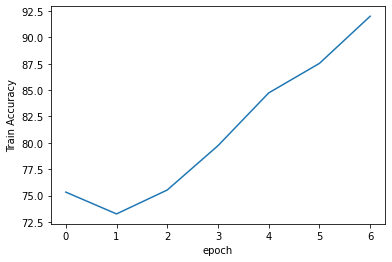

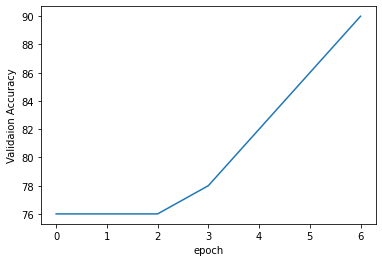

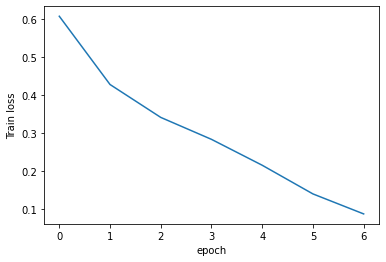

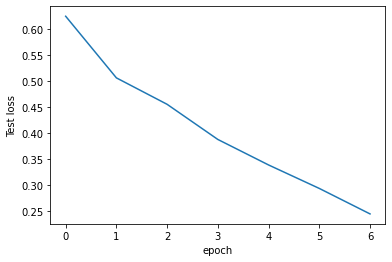

In [45]:
from matplotlib import pyplot as plt
def plot(data,labelx,labely):
  plt.plot(data)
  plt.xlabel(labelx)
  plt.ylabel(labely)
  plt.show()

plot(testacc, 'epoch','Test Accuracy')
plot(trainacc,'epoch','Train Accuracy')
plot(valacc,'epoch','Validaion Accuracy')
plot(trainloss,'epoch','Train loss')
plot(valloss,'epoch','Test loss')